2021-09-14 15:43:27.138 
  command:

    streamlit run D:\Raptor\lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2021-09-14 15:43:27.429 Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2021-09-14 15:43:27.429 NumExpr defaulting to 8 threads.


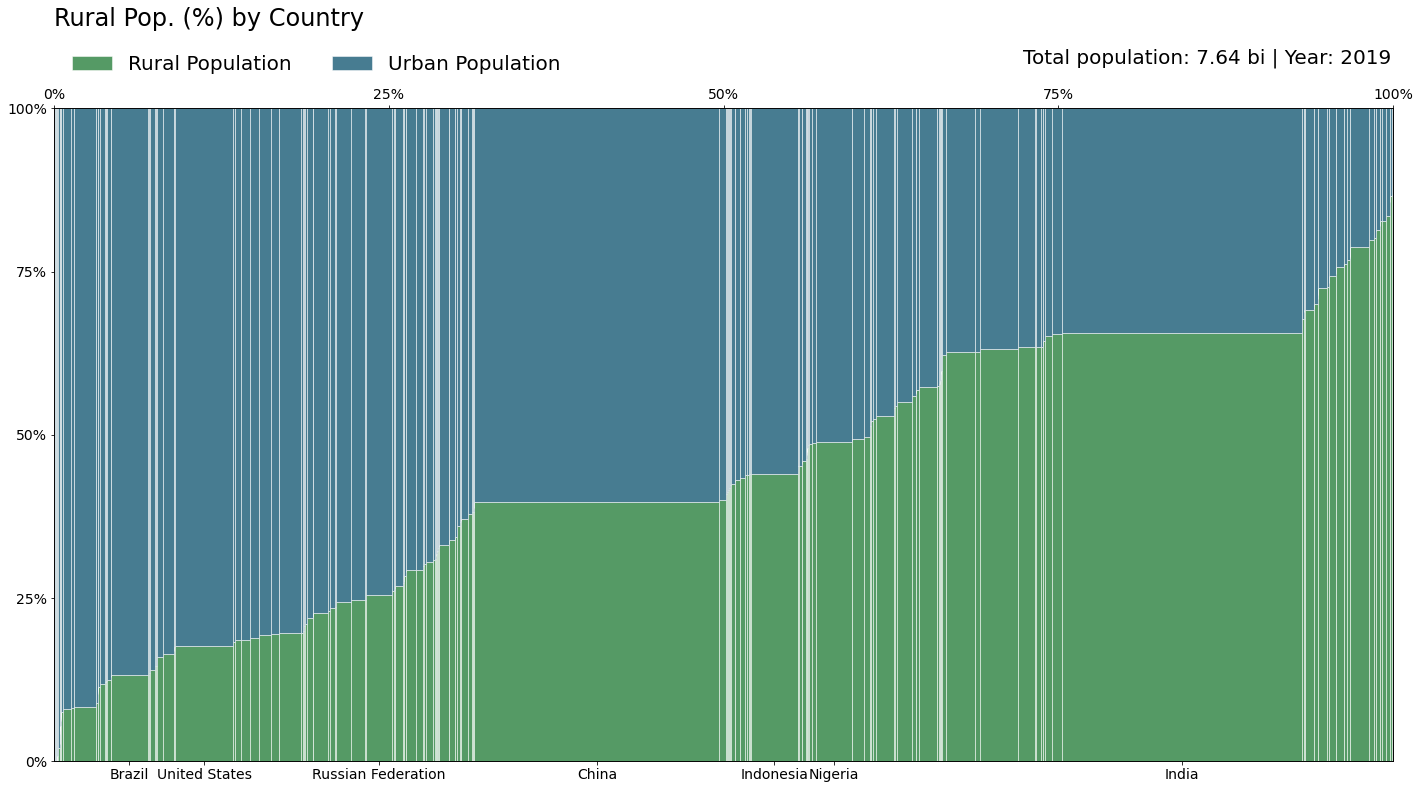

In [2]:
import streamlit as st
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import country_lists as c

def marimekko(countries_select, indicator, year, countries, highlight):
    ##################
    ###### DATA ######
    ##################
    pop_file = 'API_SP.POP.TOTL_DS2_en_csv_v2_2163507.csv'

    df = pd.read_csv('data/'+pop_file)
    var_df = pd.read_csv('data/'+c.var_dict[indicator]['file'])

    df = df.merge(var_df, 
                  left_on='Country Name', 
                  right_on='Country Name', 
                  suffixes=['_pop', '_var_df'])

    # remove non-countries
    df = df[df['Country Name'].isin(countries)]

    # remove rows with empty values for the indicator or population
    df = df[(df['{}_var_df'.format(year)].notna() & df['{}_pop'.format(year)].notna())]

    # sort rows by the indicator values 
    df.sort_values('{}_var_df'.format(year), inplace=True)

    # get y
    y = df['{}_var_df'.format(year)]/100

    # get the width of the bars (population / 1mi)
    width = df['{}_pop'.format(year)].values / 1000000

    # calculate the x position of each country
    # x is the cummulative sum of all previous widths
    x = [0]
    temp = 0
    for i in width[:-1]:
        temp += i
        x.append(temp)

    # create lists with the x ticks positions and labels
    # based on a list of countries we want to highlight
    xticks_pos = []
    xticks_labels = [] 
    for i, v in enumerate(df['Country Name']):
        if v in highlight:
            xticks_pos.append(width[i]/2 + x[i])
            xticks_labels.append(v)
            
    ##########################
    ########## PLOT ##########
    ##########################
    # define figure and axis
    fig, ax = plt.subplots(1, figsize=(24,12))

    # var_df bars
    plt.bar(x, y, align='edge', width=width, edgecolor='w', linewidth = 0.5, color='#559A65')
    plt.bar(x, np.ones(len(y))-y, bottom=y, align='edge', width=width, edgecolor='w', linewidth = 0.5, color='#477C91')
    
    # Add notes (Total population and Year)
    total_pop = df['{}_pop'.format(year)].sum()
    if total_pop > 1000000000:
        total_pop = '{:.2f} bi'.format(total_pop/1000000000)
    elif total_pop > 1000000:
        total_pop = '{:.2f} mi'.format(total_pop/1000000)
    else:
        total_pop = '{:.2f}'.format(total_pop)

    notes = 'Total population: {} | Year: {}'.format(total_pop, year)
    plt.text(x[-1], 1.07, notes, ha='right', fontsize=20)

    # title and legend
    plt.legend(c.var_dict[indicator]['legend'], ncol=2, loc='upper left',
               frameon=False, bbox_to_anchor=(0,1.11), fontsize=20)
    plt.title('{} by Country\n\n'.format(c.var_dict[indicator]['label']), 
              loc='left', fontsize=24)
    
    
    # xy limits
    plt.xlim(0, x[-1]+width[-1])
    plt.ylim(0,1)

    # xy ticks
    plt.xticks(xticks_pos, xticks_labels, fontsize=14)
    plt.yticks(np.arange(0,1.1,0.25), 
              ['{:.0f}%'.format(i*100) for i in np.arange(0,1.1,0.25)],
              fontsize=14)
    # twin y-axis to draw x-ticks at the top
    axy = ax.twiny()
    # max value on the x axis
    max_x = (x[-1] + width[-1])
    # get the values for 0%, 25%, 50%, 75%, and 100%
    x_ticks_percent = np.arange(0, max_x+1, max_x/4)
    # set ticks and labels
    axy.set_xticks(x_ticks_percent)
    axy.set_xticklabels(['{:.0f}%'.format(i*100) for i in x_ticks_percent/max_x], 
                        fontsize=14)
    return fig

#############################
###### INDICATOR INPUT ######
#############################

countries_dict = {"All":c.all_countries,
                  "European Union": c.eu, 
                  "Latin America & Caribbean": c.la_c,
                  "East Asia and Pacific": c.eap,
                  "Europe and Central Asia": c.eca,
                  "Middle East and North Africa": c.mena,
                  "North America": c.na,
                  "South Asia" : c.sa,
                  "Sub-Saharan Africa": c.ssa,
                  "Custom":False}

highlights_dict = {"All":c.highlight_all,
                  "European Union": c.highlight_eu, 
                  "Latin America & Caribbean": c.highlight_la_c,
                  "East Asia and Pacific": [],
                  "Europe and Central Asia":[],
                  "Middle East and North Africa":[],
                  "North America":[],
                  "South Asia" : [],
                  "Sub-Saharan Africa":[],
                  "Custom":[]}

countries_select = st.sidebar.selectbox(
    "Countries:",
    [*countries_dict]
)
countries = countries_dict[countries_select]

highlight_select = st.sidebar.multiselect(
    "Countries to highlight:",
    countries_dict[countries_select]
    ,highlights_dict[countries_select]
)
highlight = highlight_select

indicator = st.sidebar.radio('Select indicator:', [*c.var_dict], 0)

year = st.sidebar.slider('Year', c.var_dict[indicator]['min_year'], 
                        c.var_dict[indicator]['max_year'], 
                        c.var_dict[indicator]['max_year'])

################
##### PLOT #####
################
if len(countries)>2: 
    try:
        st.write(marimekko(countries_select, indicator, year, countries, highlight))
    except:
        st.write("No data for the current selection")
else:
    st.write("Select more countries")

